# Predicting crimes resolutions

Our objective is to predict the resolution of a crime based on victim's features, geographical and temporary data, and some other details like the weapon used and the type of agency where the crime was reported.

# Variables to use
### The complete set of variables could be found on the 'EDA' notebook. There we also specified the reasons why we use this subset of variables

## Inputs

<table>
    <tr>
        <th style="text-align: center;">Variable</td>
        <th style="text-align: center;">Description</td>
    </tr>
    <tr>
        <td style="text-align: center;">Agency Type</td>
        <td style="text-align: center;">The type of agency</td>
    </tr>
    <tr>
        <td style="text-align: center;">State</td>
        <td style="text-align: center;">The name of the state where the homicide happened</td>
    </tr>
    <tr>
        <td style="text-align: center;">Year</td>
        <td style="text-align: center;">The year of the homicide</td>
    </tr>
    <tr>
        <td style="text-align: center;">Month</td>
        <td style="text-align: center;">The month of the homicide</td>
    </tr>
    <tr>
        <td style="text-align: center;">Crime Type</td>
        <td style="text-align: center;">The type of crime</td>
    </tr>
    <tr>
        <td style="text-align: center;">Victim Sex</td>
        <td style="text-align: center;">The sex of the victim</td>
    </tr>
    <tr>
        <td style="text-align: center;">Victim Age</td>
        <td style="text-align: center;">The age of the victim</td>
    </tr>
    <tr>
        <td style="text-align: center;">Victim Race</td>
        <td style="text-align: center;">The race of the victim</td>
    </tr>
    <tr>
        <td style="text-align: center;">Weapon</td>
        <td style="text-align: center;">The weapon used</td>
    </tr>
</table>

## Output

<table>
    <tr>
        <td style="text-align: center;">**Crime Solved**</td>
        <td style="text-align: center;">Indicates whether the crime has been solved or not</td>
    </tr>
</table>

# The metric

Our client said "We don't want to create fake hope"..
It's preferable to say 'The crime won't be solved' and then it's solved, than say 'The crime will be solved' and then not.

So, the most important thing is not to say 'Yes' if a crime was not solved.

**We need to minimize the False positives:**
True predictions that are False.

The appropiate metric for this situations is **Precision: TP / (TP - FP)**

Crimes predicted as 'solved' that were solved / Crimes predicted as 'solved'.


The best value for this metric is 1 and the worst value is 0.

# 1) Preprocessing:
## -Dataset extraction.
## -Unused columns removal.
## -Used columns rename.

In [10]:
import numpy as np
import pandas as pd
import zipfile

# Extract the dataset
zipfile.ZipFile(file='dataset.zip', mode='r').extractall()

ds = pd.read_csv('dataset.csv')

# Drop unused columns
ds.drop(axis=1, inplace=True, labels=['Record ID', 'Agency Code','Agency Name', 'City', 'Incident', 
        'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Perpetrator Ethnicity', 
        'Victim Ethnicity', 'Relationship', 'Victim Count', 'Perpetrator Count', 'Record Source'])

# Column rename
BETTER_COLUMNS_NAMES = {
    'Agency Type': 'agency_type',
    'State': 'state',
    'Year': 'year',
    'Month': 'month',
    'Crime Type': 'crime_type',
    'Crime Solved': 'crime_solved',
    'Victim Sex': 'victim_sex',
    'Victim Age': 'victim_age',
    'Victim Race': 'victim_race',
    'Weapon': 'weapon',
}

ds.rename(columns=BETTER_COLUMNS_NAMES, inplace=True)

ds.columns

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['agency_type', 'state', 'year', 'month', 'crime_type', 'crime_solved',
       'victim_sex', 'victim_age', 'victim_race', 'weapon'],
      dtype='object')

## -Output variable balance

In [11]:
from sklearn.utils import shuffle

# Left the crime_solved='Yes' rows at the end
ds.sort_values(by='crime_solved', inplace=True)

# Drop rows to get the same number of examples of 'Yes' and 'No'
ds.drop(ds.index[-257890:], inplace=True)

ds = shuffle(ds)

print(ds.crime_solved.value_counts())

No     190282
Yes    190282
Name: crime_solved, dtype: int64


## -Splitting the dataset into train, test and validation

In [12]:
from sklearn.model_selection import train_test_split

# 60% train, 30% test, 10% validation
train, not_train = train_test_split(ds, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.75)

# 2) Defining a generic function to evaluate the different models

In [13]:
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline
scaler = StandardScaler()

def evaluate_model(model, extract_inputs_outputs, include_validation=False):
    sets = [('train', train), ('test', test)]
    if (include_validation):
        sets.append(('validation', validation))
    
    for set_name, set_data in sets:
        inputs, outputs = extract_inputs_outputs(set_data)

        predictions = model.predict(inputs)

        predictions = predictions.astype(np.float64).round()
        
        print('Model evaluation on dataset:' + set_name)
        
        print('Accuracy score:', accuracy_score(outputs, predictions))
        
        print('Precision score:', precision_score(outputs, predictions))
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['not solved', 'solved'], rotation=45)
        plt.yticks([0, 1], ['not solved', 'solved'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions),
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()
        

# 3) Models:

# First attempt: Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

(The main challenge here is to handle the categorical variables. This is a common preprocessing step where we have to convert any possible text value into a new column. It's necessary since the Logistic Regression only handles numbers)

In [15]:
import datetime as d

def lr_extract_inputs_outputs(dataset):
    ds = dataset.copy()
    
    # month format
    ds.month = ds.month.apply(lambda x: d.datetime.strptime(x[:3], '%b').month)
    
    # agency type
    for agency_type in ds.agency_type.unique():
        ds[agency_type.lower().replace(' ', '_')] = (ds.agency_type == agency_type)
    ds.drop(columns=['agency_type'], inplace=True)
    
    # state
    for state in ds.state.unique():
        ds[state.lower().replace(' ', '_')] = (ds.state == state)
    ds.drop(columns=['state'], inplace=True)
        
    # crime type
    for crime_type in ds.crime_type.unique():
        ds[crime_type.lower().replace(' ', '_')] = (ds.crime_type == crime_type)
    ds.drop(columns=['crime_type'], inplace=True)
        
    # victim sex
    ds = ds[ds.victim_sex != 'Unknown']
    for victim_sex in ds.victim_sex.unique():
        ds[victim_sex.lower().replace(' ', '_')] = (ds.victim_sex == victim_sex)
    ds.drop(columns=['victim_sex'], inplace=True)
        
    # victim age
    ds = ds[ds.victim_age != 998]

    # victim race
    ds = ds[ds.victim_race != 'Unknown']
    for victim_race in ds.victim_race.unique():
        ds[victim_race.lower().replace(' ','_')] = (ds.victim_race == victim_race)
    ds.drop(columns=['victim_race'], inplace=True)

    # weapon
    ds = ds[ds.weapon != 'Unknown']

    for weapon in ds.weapon.unique():
        ds[weapon.lower().replace(' ', '_')] = (ds.weapon == weapon)
    ds.drop(columns=['weapon'], inplace=True)
    
    # crime_solved
    ds['crime_solved'] = (ds.crime_solved == 'Yes')
    
    inputs = ds.drop(columns=['crime_solved'])
    outputs = ds.crime_solved
    
    return [scaler.fit_transform(inputs).astype(np.float64), outputs.values]

In [16]:
lr_model = LogisticRegression()

In [17]:
inputs, outputs = lr_extract_inputs_outputs(train)

lr_model.fit(inputs, outputs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Model evaluation on dataset:train
Accuracy score: 0.7501511077267211
Precision score: 0.7388334209143458


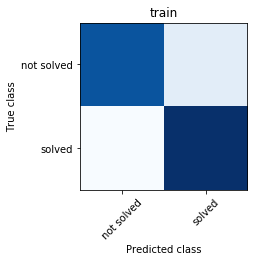

Model evaluation on dataset:test
Accuracy score: 0.7154351411384501
Precision score: 0.7091810966810966


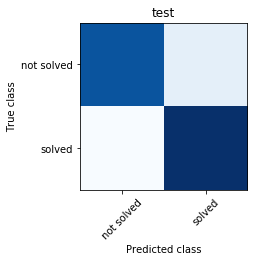

Model evaluation on dataset:validation
Accuracy score: 0.6901215545283342
Precision score: 0.6813722890927408


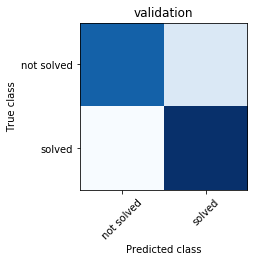

In [18]:
evaluate_model(lr_model, lr_extract_inputs_outputs, include_validation=True)

## Conclusions:
The logistic regression isn't doing it very well. The precission score for the test set was 0.68 and we can see on the confussion matrix that it's getting many False Positives. Clearly, we can't present this model to our client.

# 2nd model: Decision Trees

(Here we faced the problem of converting every text value into a numeric one. In the case of the 'state' column it was a big work to map the 50 different values. Maybe a better approach would be to create the map in a dynamic way, as we can get the possible values of a column by ds.column_name.unique(). This could be an improvement for the future work)

In [19]:
import datetime as d

def dt_extract_inputs_outputs(dataset):
    ds = dataset.copy()

    # month format
    ds.month = ds.month.apply(lambda x: d.datetime.strptime(x[:3], '%b').month)
    
    # victim sex
    ds = ds[ds.victim_sex != 'Unknown']

    # victim age
    ds = ds[ds.victim_age != 998]

    # victim race
    ds = ds[ds.victim_race != 'Unknown']

    # weapon
    ds = ds[ds.weapon != 'Unknown']

    ds['weapon'] = ds.weapon.map({'Blunt Object': 1, 'Rifle': 2, 'Knife': 3,
       'Gun': 4, 'Fire': 5, 'Suffocation': 6, 'Strangulation': 7,
       'Explosives': 8, 'Drugs': 9, 'Drowning': 10, 'Poison': 11, 'Fall': 12,
       'Handgun': 13, 'Firearm': 14, 'Shotgun': 15})
    
    # agency type
    ds['agency_type'] = ds.agency_type.map({'Municipal Police': 1, 'Sheriff': 2, 'County Police': 3, 
                        'State Police': 4, 'Special Police': 5, 'Tribal Police': 5, 'Regional Police': 6})
    
    # crime_solved
    ds['crime_solved'] = (ds.crime_solved == 'Yes')
    
    
    ds['victim_race'] = ds.victim_race.map({'Black': 1, 'White': 2,
                                            'Asian/Pacific Islander': 3,
                                            'Native American/Alaska Native':4})
    
    # state
    ds['state'] = ds.state.map({'Pennsylvania': 1, 'Florida': 2, 'Illinois': 3, 'Louisiana': 4, 'California': 5,
       'New Jersey': 6, 'Texas': 7, 'Tennessee': 8, 'Michigan': 9, 'Maryland': 10,
       'New York': 11, 'North Carolina': 12, 'Missouri': 13, 'Ohio': 14, 'Georgia': 15,
       'Oklahoma': 16, 'Nevada': 17, 'West Virginia': 18, 'District of Columbia': 19,
       'Virginia': 20, 'Colorado': 21, 'Kentucky': 22, 'Minnesota': 23, 'New Mexico': 24,
       'Arizona': 25, 'Idaho': 26, 'Oregon': 27, 'Arkansas': 28, 'Indiana': 29, 'Wisconsin': 30,
       'Mississippi': 31, 'Connecticut': 32, 'Washington': 33, 'Maine': 34,
       'Massachusetts': 35, 'Iowa': 36, 'South Carolina': 37, 'Alabama': 38, 'Nebraska': 39,
       'Alaska': 40, 'Utah': 41, 'Delaware': 42, 'Hawaii': 43, 'Vermont': 44, 'Wyoming': 45,
       'Rhodes Island': 46, 'Kansas': 47, 'Montana': 48, 'New Hampshire': 49,
       'North Dakota': 50, 'South Dakota': 51})
    
    # crime solved
    ds['crime_type'] = ds.crime_type.map({'Murder or Manslaughter': 1, 'Manslaughter by Negligence': 2})
    
    # victim sex
    ds['victim_sex'] = ds.victim_sex.map({'Male': 1, 'Female': 2})
    
    inputs = ds.drop(columns=['crime_solved'])
    outputs = ds.crime_solved
    
    return [inputs.values, outputs.values]

In [20]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=15);

inputs, outputs = dt_extract_inputs_outputs(train)
dt_classifier.fit(inputs, outputs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Model evaluation on dataset:train
Accuracy score: 0.8240487352164291
Precision score: 0.7852440895517463


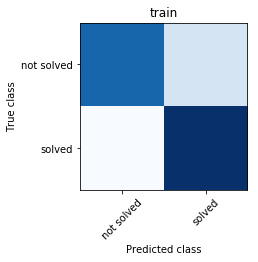

Model evaluation on dataset:test
Accuracy score: 0.787963430794017
Precision score: 0.7554232453230728


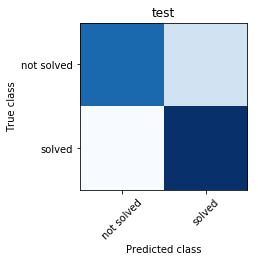

Model evaluation on dataset:validation
Accuracy score: 0.7891628145865434
Precision score: 0.7561860280234523


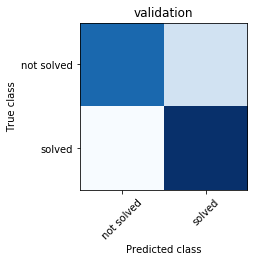

In [21]:
evaluate_model(dt_classifier, dt_extract_inputs_outputs, include_validation=True)

In [22]:
import graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=['agency_type', 'state', 'year', 'month', 'crime_type',
                    'victim_sex', 'victim_age', 'victim_race', 'weapon'],
        class_names=[' Not solved', 'Solved'],
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

graph_tree(dt_classifier)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

## Feature importances

<BarContainer object of 9 artists>

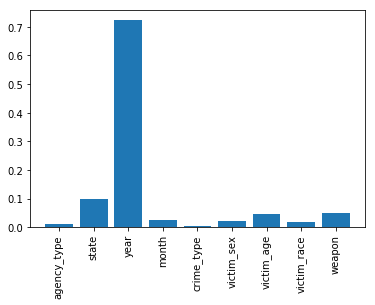

In [23]:
feature_importances = dt_classifier. feature_importances_

plt.xticks(rotation='vertical')
plt.bar(x=['agency_type', 'state', 'year', 'month', 'crime_type', 'victim_sex', 
           'victim_age', 'victim_race', 'weapon'], height=feature_importances)

## Conclusions
The model is giving an extremely big importance to the 'year' variable, followed from afar by the 'state' variable. We don't know how good is this situation. We tried to use a scaler to 'normalize' the values for the year (pretty higher than the other variables) but the result was the same.

Related to the precission metric, the model achieved a better score than the Logistic Regression (**0.75** for test and validation). 

This score was achieved with a **max_depth** of 15. We choose that number after trying with many and seeing that: **1)** a lower depth causes worst scores and **2)** a bigger depth causes overfitting (only improves predictions on train)

# 3rd Model: Neural Network

In [24]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from sklearn.preprocessing import StandardScaler

In [35]:
nn_model_1 = Sequential([   
    Dense(500, input_shape=(84,)),
    Activation('tanh'),
    
    Dropout(0.2),

    Dense(500),
    Activation('tanh'),
    
    Dense(1),
    Activation('sigmoid'),
])

In [36]:
nn_model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [37]:
scaler = StandardScaler()
inputs, outputs = lr_extract_inputs_outputs(train)
inputs_test, outputs_test = lr_extract_inputs_outputs(test)
history = nn_model_1.fit(
    inputs,
    outputs,
    epochs=20,
    batch_size=200,
    validation_data=(
        inputs_test,
        outputs_test,
    )
)

Train on 210115 samples, validate on 104897 samples
Epoch 1/20
210115/210115 [==============================] - 19s 88us/step - loss: 0.4955 - acc: 0.7551 - val_loss: 0.5088 - val_acc: 0.7467
Epoch 2/20
210115/210115 [==============================] - 18s 84us/step - loss: 0.4413 - acc: 0.7833 - val_loss: 0.5082 - val_acc: 0.7525
Epoch 3/20
210115/210115 [==============================] - 17s 80us/step - loss: 0.4290 - acc: 0.7863 - val_loss: 0.4958 - val_acc: 0.7527
Epoch 4/20
210115/210115 [==============================] - 18s 84us/step - loss: 0.4214 - acc: 0.7881 - val_loss: 0.5084 - val_acc: 0.7454
Epoch 5/20
210115/210115 [==============================] - 18s 84us/step - loss: 0.4138 - acc: 0.7911 - val_loss: 0.5101 - val_acc: 0.7540
Epoch 6/20
210115/210115 [==============================] - 17s 79us/step - loss: 0.4070 - acc: 0.7941 - val_loss: 0.5142 - val_acc: 0.7508
Epoch 7/20
210115/210115 [==============================] - 18s 83us/step - loss: 0.4027 - acc: 0.7954 - val

Model evaluation on dataset:train
Accuracy score: 0.8089760369321563
Precision score: 0.7778779023252289


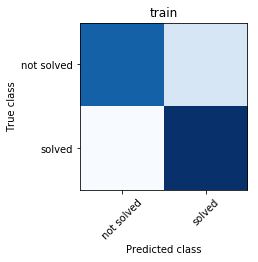

Model evaluation on dataset:test
Accuracy score: 0.7424711860205726
Precision score: 0.7224786324786325


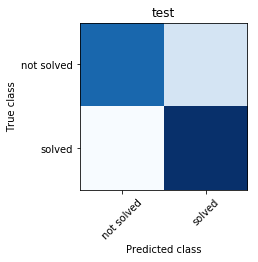

Model evaluation on dataset:validation
Accuracy score: 0.719254693830965
Precision score: 0.6963144226927687


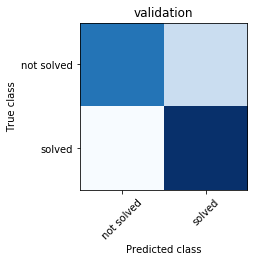

In [38]:
evaluate_model(nn_model_1, lr_extract_inputs_outputs, include_validation=True)

## Conclusions
The results of the neural network are in between the previous models we trained. We tried tuning the network in some aspects (dropout layer, optimizer, learning rate, etc) but didn't get any rewarding changes at all. The model overfits too fast. Keeping the current values to on edge of overfiting got us an accuracy measure on test that won't go up 71% with a precission of 69%.

In [25]:
nn_model = Sequential([   
    Dense(500, input_shape=(84,)),
    Activation('tanh'),
    
    Dropout(0.2),

    Dense(500),
    Activation('tanh'),
    
    Dense(1),
    Activation('sigmoid'),
])

In [26]:
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [32]:
scaler = StandardScaler()
inputs, outputs = lr_extract_inputs_outputs(train)
inputs_test, outputs_test = lr_extract_inputs_outputs(test)
history = nn_model.fit(
    inputs,
    outputs,
    epochs=300,
    batch_size=200,
    validation_data=(
        inputs_test,
        outputs_test,
    )
)

Train on 210115 samples, validate on 104897 samples
Epoch 1/300
210115/210115 [==============================] - 17s 80us/step - loss: 0.3954 - acc: 0.7981 - val_loss: 0.5248 - val_acc: 0.7492
Epoch 2/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3941 - acc: 0.7985 - val_loss: 0.5316 - val_acc: 0.7464
Epoch 3/300
210115/210115 [==============================] - 17s 80us/step - loss: 0.3920 - acc: 0.7999 - val_loss: 0.5378 - val_acc: 0.7449
Epoch 4/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3917 - acc: 0.7996 - val_loss: 0.5490 - val_acc: 0.7368
Epoch 5/300
210115/210115 [==============================] - 18s 84us/step - loss: 0.3898 - acc: 0.8014 - val_loss: 0.5392 - val_acc: 0.7513
Epoch 6/300
210115/210115 [==============================] - 18s 85us/step - loss: 0.3901 - acc: 0.8008 - val_loss: 0.5481 - val_acc: 0.7508
Epoch 7/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3883 - acc: 0.801

210115/210115 [==============================] - 17s 81us/step - loss: 0.3607 - acc: 0.8155 - val_loss: 0.6558 - val_acc: 0.7313
Epoch 59/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3603 - acc: 0.8150 - val_loss: 0.6705 - val_acc: 0.7353
Epoch 60/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3598 - acc: 0.8152 - val_loss: 0.6701 - val_acc: 0.7280
Epoch 61/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3591 - acc: 0.8163 - val_loss: 0.6668 - val_acc: 0.7300
Epoch 62/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3591 - acc: 0.8160 - val_loss: 0.6737 - val_acc: 0.7322
Epoch 63/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3580 - acc: 0.8163 - val_loss: 0.6733 - val_acc: 0.7305
Epoch 64/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3588 - acc: 0.8162 - val_loss: 0.6695 - val_acc: 0.7318
Epoch 65/300
210115

210115/210115 [==============================] - 17s 82us/step - loss: 0.3456 - acc: 0.8229 - val_loss: 0.7404 - val_acc: 0.7176
Epoch 116/300
210115/210115 [==============================] - 17s 80us/step - loss: 0.3451 - acc: 0.8230 - val_loss: 0.7423 - val_acc: 0.7239
Epoch 117/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3442 - acc: 0.8242 - val_loss: 0.7398 - val_acc: 0.7229
Epoch 118/300
210115/210115 [==============================] - 18s 84us/step - loss: 0.3452 - acc: 0.8234 - val_loss: 0.7336 - val_acc: 0.7191
Epoch 119/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3442 - acc: 0.8237 - val_loss: 0.7488 - val_acc: 0.7236
Epoch 120/300
210115/210115 [==============================] - 17s 83us/step - loss: 0.3444 - acc: 0.8238 - val_loss: 0.7414 - val_acc: 0.7171
Epoch 121/300
210115/210115 [==============================] - 17s 83us/step - loss: 0.3440 - acc: 0.8236 - val_loss: 0.7551 - val_acc: 0.7079
Epoch 122/300

210115/210115 [==============================] - 16s 76us/step - loss: 0.3368 - acc: 0.8277 - val_loss: 0.8206 - val_acc: 0.7055
Epoch 173/300
210115/210115 [==============================] - 16s 76us/step - loss: 0.3357 - acc: 0.8282 - val_loss: 0.8124 - val_acc: 0.7186
Epoch 174/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3360 - acc: 0.8284 - val_loss: 0.8146 - val_acc: 0.7070
Epoch 175/300
210115/210115 [==============================] - 17s 83us/step - loss: 0.3354 - acc: 0.8281 - val_loss: 0.8168 - val_acc: 0.7143
Epoch 176/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3351 - acc: 0.8290 - val_loss: 0.8101 - val_acc: 0.7054
Epoch 177/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3360 - acc: 0.8281 - val_loss: 0.8040 - val_acc: 0.7084
Epoch 178/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3359 - acc: 0.8278 - val_loss: 0.8097 - val_acc: 0.7123
Epoch 179/300

210115/210115 [==============================] - 18s 85us/step - loss: 0.3300 - acc: 0.8316 - val_loss: 0.8578 - val_acc: 0.7090
Epoch 230/300
210115/210115 [==============================] - 18s 87us/step - loss: 0.3304 - acc: 0.8317 - val_loss: 0.8588 - val_acc: 0.7020
Epoch 231/300
210115/210115 [==============================] - 19s 89us/step - loss: 0.3308 - acc: 0.8310 - val_loss: 0.8663 - val_acc: 0.7014
Epoch 232/300
210115/210115 [==============================] - 19s 88us/step - loss: 0.3303 - acc: 0.8304 - val_loss: 0.8766 - val_acc: 0.7068
Epoch 233/300
210115/210115 [==============================] - 18s 86us/step - loss: 0.3301 - acc: 0.8307 - val_loss: 0.8603 - val_acc: 0.7080
Epoch 234/300
210115/210115 [==============================] - 17s 81us/step - loss: 0.3294 - acc: 0.8318 - val_loss: 0.8607 - val_acc: 0.7079
Epoch 235/300
210115/210115 [==============================] - 17s 82us/step - loss: 0.3308 - acc: 0.8308 - val_loss: 0.8632 - val_acc: 0.7059
Epoch 236/300

210115/210115 [==============================] - 17s 81us/step - loss: 0.3254 - acc: 0.8344 - val_loss: 0.9165 - val_acc: 0.7003
Epoch 287/300
210115/210115 [==============================] - 17s 80us/step - loss: 0.3265 - acc: 0.8332 - val_loss: 0.9199 - val_acc: 0.6993
Epoch 288/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3268 - acc: 0.8327 - val_loss: 0.9258 - val_acc: 0.6890
Epoch 289/300
210115/210115 [==============================] - 17s 79us/step - loss: 0.3264 - acc: 0.8335 - val_loss: 0.9291 - val_acc: 0.7058
Epoch 290/300
210115/210115 [==============================] - 17s 80us/step - loss: 0.3259 - acc: 0.8336 - val_loss: 0.9207 - val_acc: 0.6974
Epoch 291/300
210115/210115 [==============================] - 16s 78us/step - loss: 0.3271 - acc: 0.8331 - val_loss: 0.9255 - val_acc: 0.7037
Epoch 292/300
210115/210115 [==============================] - 622s 3ms/step - loss: 0.3255 - acc: 0.8339 - val_loss: 0.9267 - val_acc: 0.6948
Epoch 293/300

Model evaluation on dataset:train
Accuracy score: 0.8552173809580468
Precision score: 0.8515467555745424


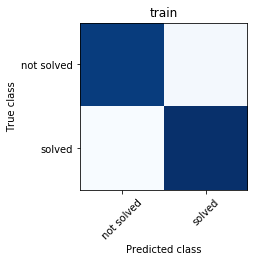

Model evaluation on dataset:test
Accuracy score: 0.6938615975671373
Precision score: 0.7104252538453805


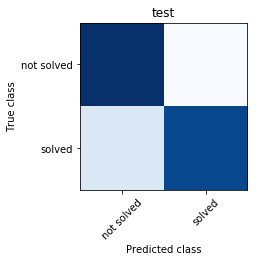

Model evaluation on dataset:validation
Accuracy score: 0.6660674542030475
Precision score: 0.6750320999182912


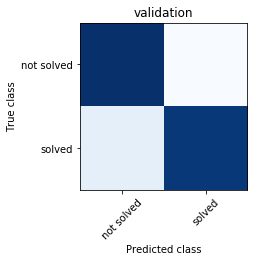

In [34]:
evaluate_model(nn_model, lr_extract_inputs_outputs, include_validation=True)

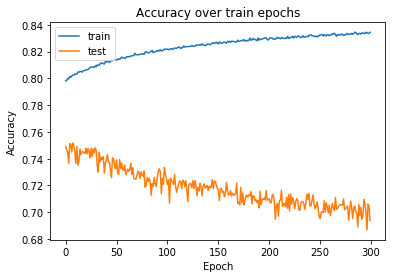

In [33]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Accuracy over training epochs
In this last try, we set up the epochs up to 300 to have a clearer visualization of the overfit consecuences. 

# What does the client get?
Based on what we've learned so far from the data, we would deliver to our client the decision tree model, mainly because of its readability, and because it explains in some way the behavior of its "decisions". Even though the graphic to describe it is to complex, we are able to have a look at the Feature Importances. It's a shame that this particular problem we are approaching has such a huge diference in the influence of its inputs variables (the year is clearly deciding a LOT about the output). Although, given the case, this info can still be useful to the client.
On the other hand, the "black box" paradigm of the neural network keeps these matters in the dark, so we believe the decision tree to be a more honest product to deliver, and also a more eficcient one given the metrics we are consulting.